In [11]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt


class SVMDualProblem:
    def __init__(self, C=1.0, kernel='rbf', sigma=0.1, degree=2):
        self.C = C
        if kernel == 'poly':
            self.kernel = self._polynomial_kernel
            self.c = 1
            self.degree = degree
        else:
            self.kernel = self._rbf_kernel
            self.sigma = sigma

        self.X = None
        self.y = None
        self.alpha = None
        self.b = 0
        self.ones = None

    def _rbf_kernel(self, X1, X2):
        return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], axis=2) ** 2)

    def _polynomial_kernel(self, X1, X2):
        return (self.c + X1.dot(X2.T)) ** self.degree

    def fit(self, X, y, lr=1e-3, epochs=500):

        self.X = X
        self.y = y

        # (500,)
        self.alpha = np.random.random(X.shape[0])
        self.b = 0
        # (500,)
        self.ones = np.ones(X.shape[0])

        # (500,500) =      (500,500) *        (500,500)
        y_iy_jk_ij = np.outer(y, y) * self.kernel(X, X)

        losses = []
        for _ in range(epochs):
            # (500,)  =    (500,)      (500,500).(500,)=(500,)
            gradient = self.ones - y_iy_jk_ij.dot(self.alpha)
            # Same code
            # gradient = self.ones - np.sum(y_iy_jk_ij * self.alpha)

            self.alpha = self.alpha + lr * gradient

            self.alpha[self.alpha > self.C] = self.C
            self.alpha[self.alpha < 0] = 0

            #                                        (500,500)                            (500,500)
            loss = np.sum(self.alpha) - 0.5 * np.sum(np.outer(self.alpha, self.alpha) * y_iy_jk_ij)
            losses.append(loss)

        index = np.where((self.alpha) > 0 & (self.alpha < self.C))[0]
        # (m,)= (m,)       (n,).(n,m)= (m,)
        b_i = y[index] - (self.alpha * y).dot(self.kernel(X, X[index]))
        # Alternative code
        # b_i = y[index] - np.sum((self.alpha * y).reshape(-1, 1)*self.kernel(X, X[index]), axis=0)
        self.b = np.mean(b_i)

        plt.plot(losses)
        plt.title("loss per epochs")
        plt.show()

    def _decision_function(self, X):
        return (self.alpha * self.y).dot(self.kernel(self.X, X)) + self.b

    def predict(self, X):
        return np.sign(self._decision_function(X))

    def score(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y == y_hat)

    def plot_decision_boundary(self):
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, s=50, cmap=plt.cm.Paired, alpha=.5)
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = self._decision_function(xy).reshape(XX.shape)

        # plot decision boundary and margins
        ax.contour(XX, YY, Z, colors=['b', 'g', 'r'], levels=[-1, 0, 1], alpha=0.5,
                   linestyles=['--', '-', '--'], linewidths=[2.0, 2.0, 2.0])

        # highlight the support vectors
        ax.scatter(self.X[:, 0][self.alpha > 0.], self.X[:, 1][self.alpha > 0.], s=50,
                   linewidth=1, facecolors='none', edgecolors='k')

        plt.show()


In [12]:
class SampleData:
    def get_moon(self, n_samples, noise=0.05):
        noisy_moons = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=6)
        return noisy_moons[0], noisy_moons[1]

    def get_donut(self, n_samples, noise=0.05, factor=0.5):
        noisy_circles = datasets.make_circles(n_samples=n_samples, factor=factor, noise=noise)
        return noisy_circles[0], noisy_circles[1]

    def plot(self, X, y):
        ax = plt.gca()
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
        plt.show()

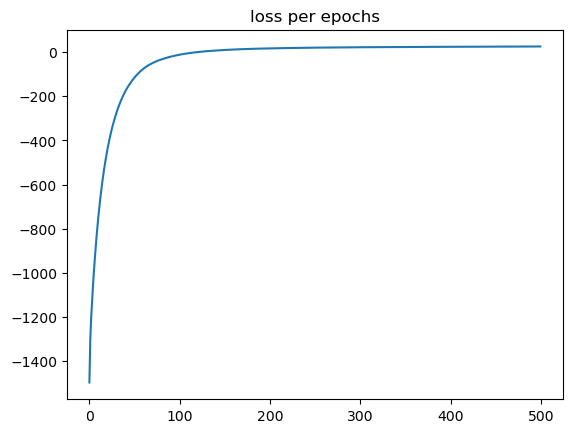

train score: 0.998


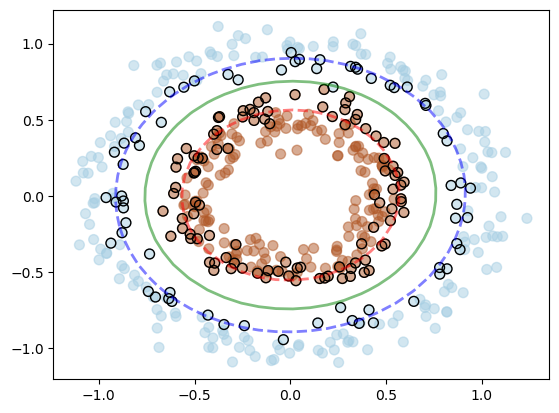

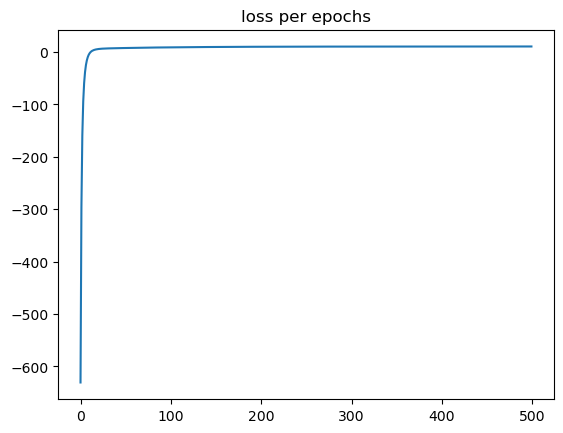

train score: 1.0


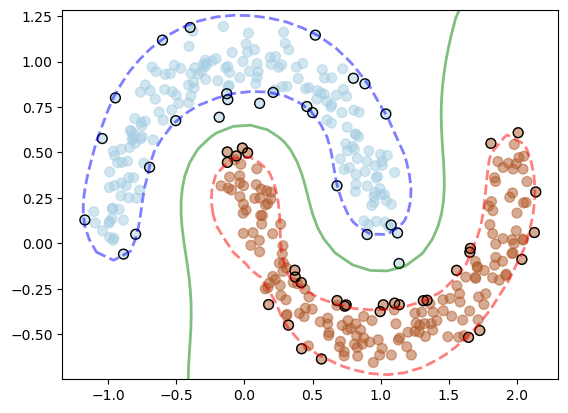

In [13]:
if __name__ == '__main__':
    sample = SampleData()
    X, y = sample.get_donut(n_samples=500, noise=0.08)
    y[y == 0] = -1

    svm = SVMDualProblem(C=1.0, kernel='poly', degree=2)
    svm.fit(X, y, lr=1e-3)
    print("train score:", svm.score(X, y))
    svm.plot_decision_boundary()

    X, y = sample.get_moon(n_samples=400, noise=0.1)
    y[y == 0] = -1

    svm = SVMDualProblem(C=1.0, kernel='rbf', sigma=0.5)
    svm.fit(X, y, lr=1e-2)
    print("train score:", svm.score(X, y))
    svm.plot_decision_boundary()

Automatically created module for IPython interactive environment


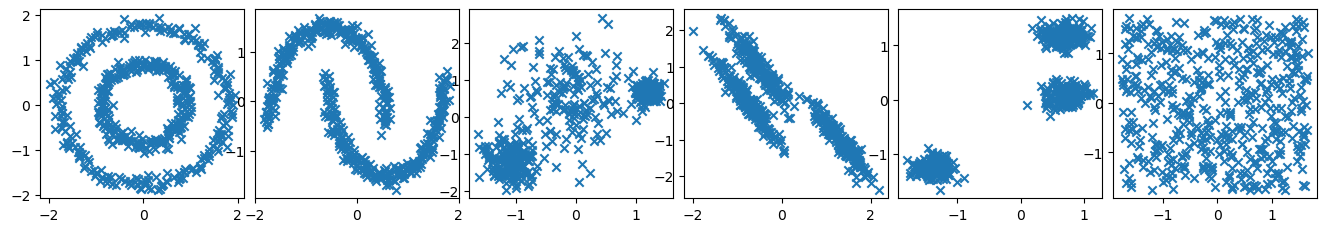

In [14]:
import time
import warnings
import collections
import numpy as np
import matplotlib.pyplot as plt
import queue
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice



print(__doc__)


np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(20,4))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.95, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    plt.subplot(len(dataset), len(params), plot_num)
    plt.scatter(X[:,0],X[:,1],marker='x')
    plt.show
    plot_num+=1

# dataset,algo_params=(datasets[1])
# X,y=(dataset)
# X=StandardScaler().fit_transform(X)
# plt.scatter(X[:,0],X[:,1],marker='x')
# plt.show()  


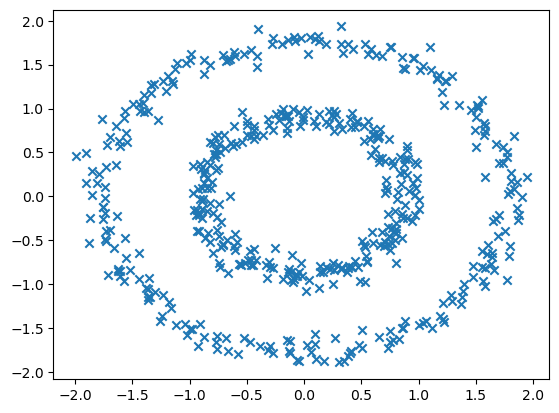

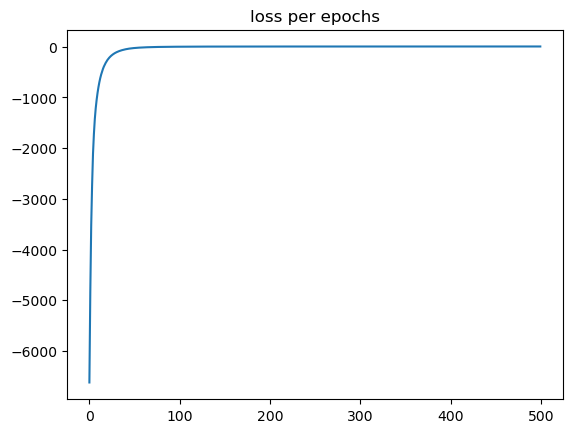

train score: 1.0


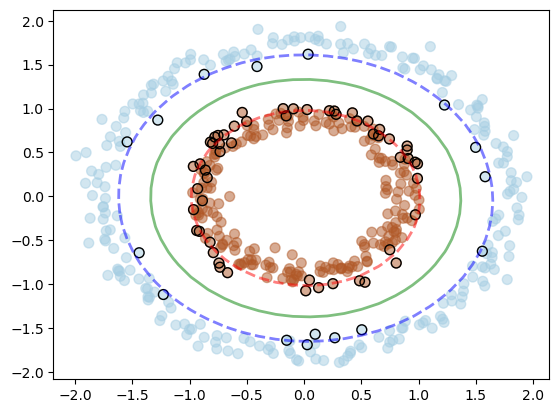

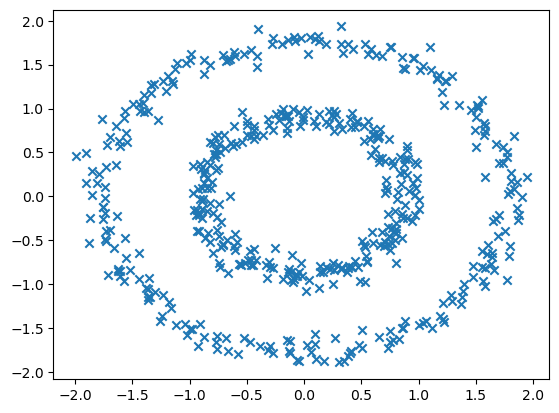

/home/girish/miniconda3/envs/bathy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/girish/miniconda3/envs/bathy/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


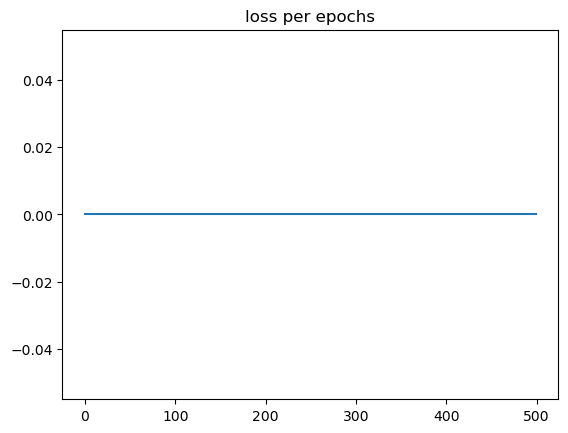

train score: 0.0


/home/girish/miniconda3/envs/bathy/lib/python3.9/site-packages/matplotlib/contour.py:1486: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/girish/miniconda3/envs/bathy/lib/python3.9/site-packages/matplotlib/contour.py:1487: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/tmp/ipykernel_140954/3024482359.py:94: UserWarning: No contour levels were found within the data range.
  ax.contour(XX, YY, Z, colors=['b', 'g', 'r'], levels=[-1, 0, 1], alpha=0.5,


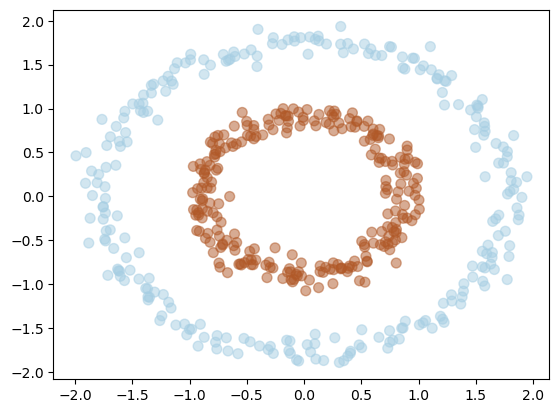

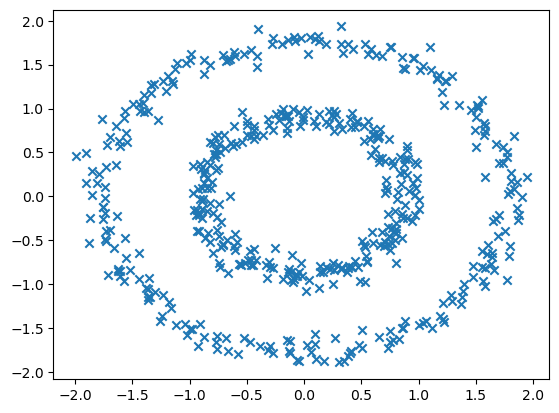

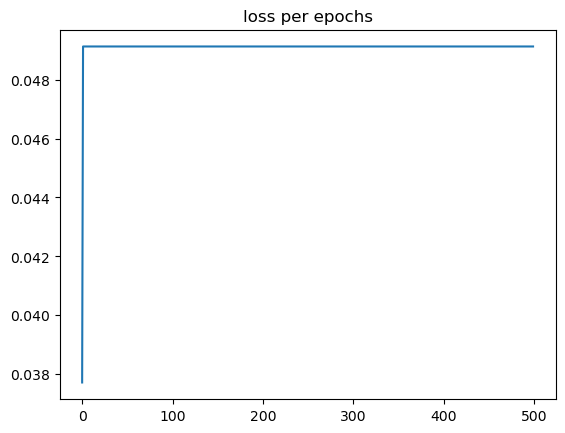

train score: 1.0


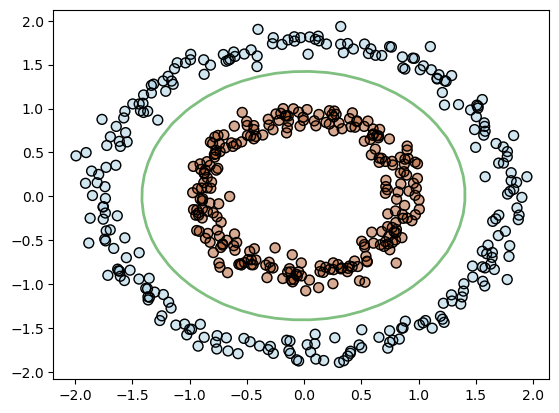

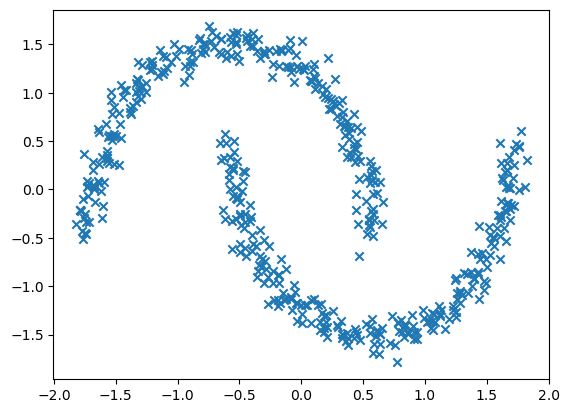

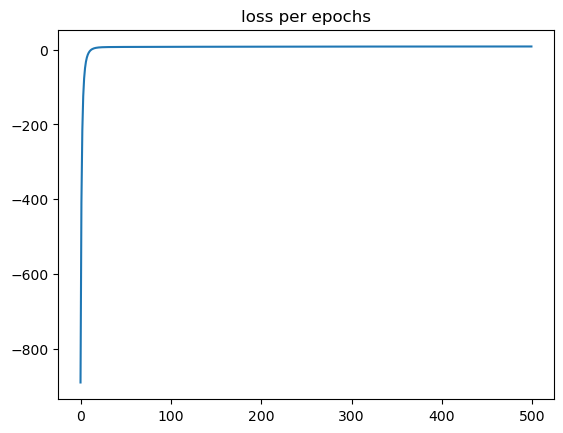

train score: 1.0


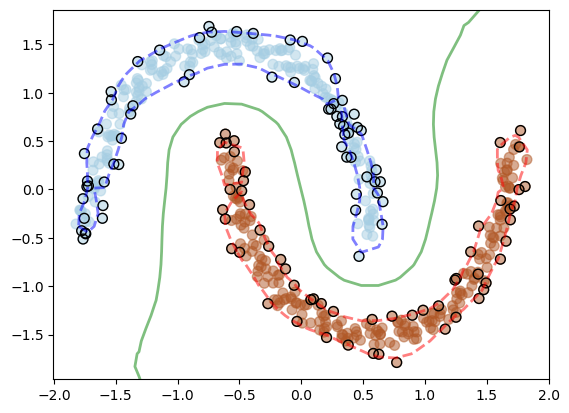

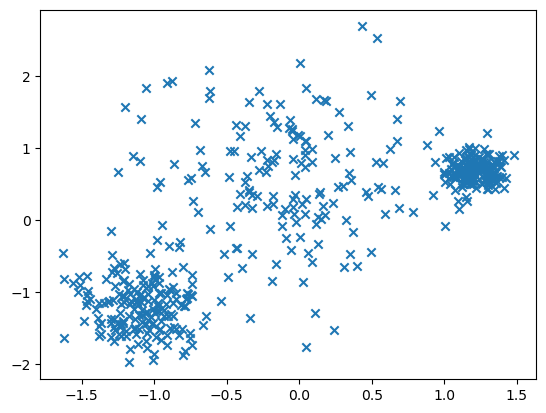

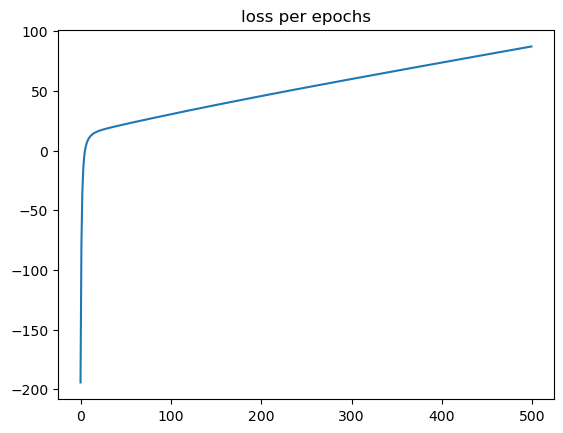

train score: 0.988


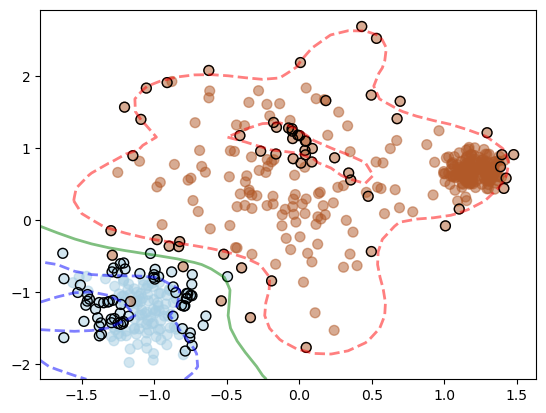

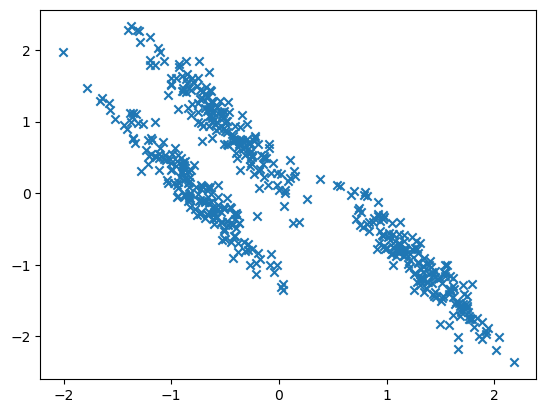

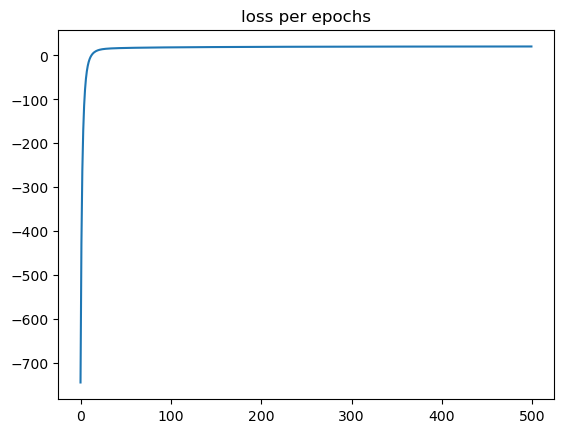

train score: 1.0


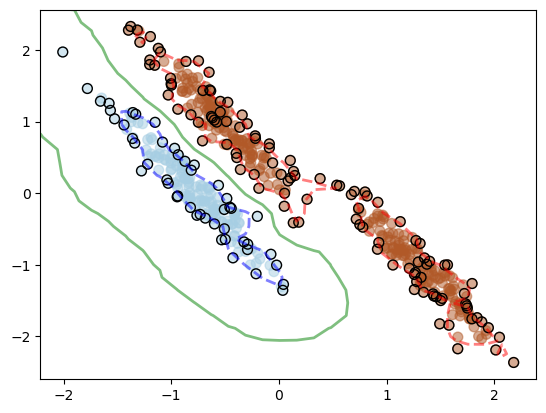

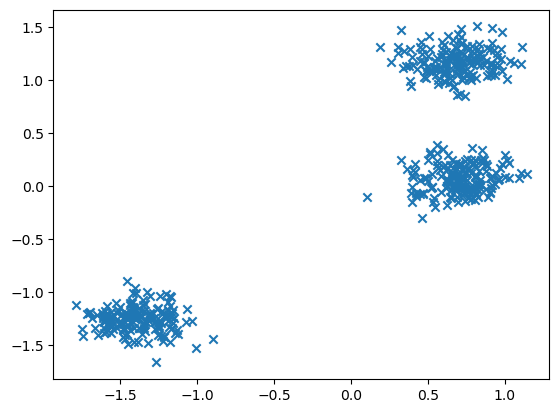

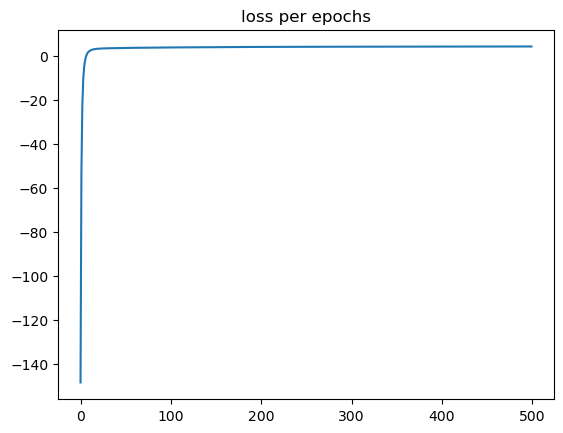

train score: 1.0


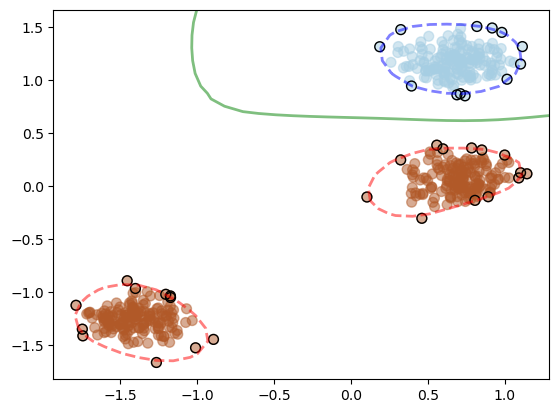

In [15]:
dataset,algo_params=(datasets[0])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1

svm = SVMDualProblem(C=20.0, kernel='poly', degree=2)
svm.fit(X, y, lr=1e-3)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()

# dataset,algo_params=(datasets[1])
# X,y=(dataset)
# X=StandardScaler().fit_transform(X)
# plt.scatter(X[:,0],X[:,1],marker='x')
# plt.show()
# y[y == 0] = -1

dataset,algo_params=(datasets[0])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1
svm = SVMDualProblem(C=0, kernel='poly', degree=2)
svm.fit(X, y, lr=1e-3)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()

# dataset,algo_params=(datasets[1])
# X,y=(dataset)
# X=StandardScaler().fit_transform(X)
# plt.scatter(X[:,0],X[:,1],marker='x')
# plt.show()
# y[y == 0] = -1

dataset,algo_params=(datasets[0])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1
svm = SVMDualProblem(C=0.0001, kernel='poly', degree=2)
svm.fit(X, y, lr=1e-3)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()


dataset,algo_params=(datasets[1])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1

svm = SVMDualProblem(C=20.0, kernel='rbf', sigma=0.5)
svm.fit(X, y, lr=1e-2)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()

dataset,algo_params=(datasets[2])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1
y[y == 1] = 1
y[y == 2] = 1

svm = SVMDualProblem(C=20, kernel='rbf', sigma=0.8)
svm.fit(X, y, lr=1e-2)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()  

dataset,algo_params=(datasets[3])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1
y[y == 1] = 1
y[y == 2] = 1    

svm = SVMDualProblem(C=20.0, kernel='rbf', sigma=0.25)
svm.fit(X, y, lr=1e-2)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary() 

dataset,algo_params=(datasets[4])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1
y[y == 1] = 1
y[y == 2] = 1    

svm = SVMDualProblem(C=20.0, kernel='rbf', sigma=0.5)
svm.fit(X, y, lr=1e-2)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()  


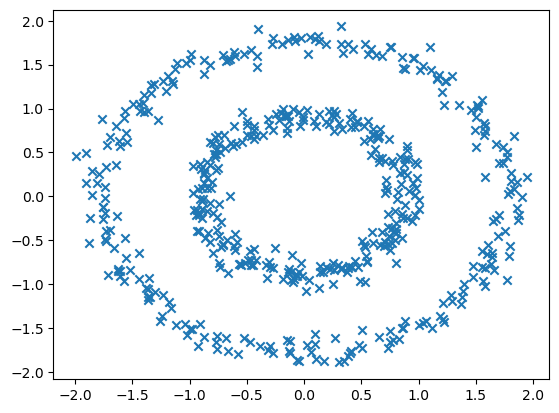

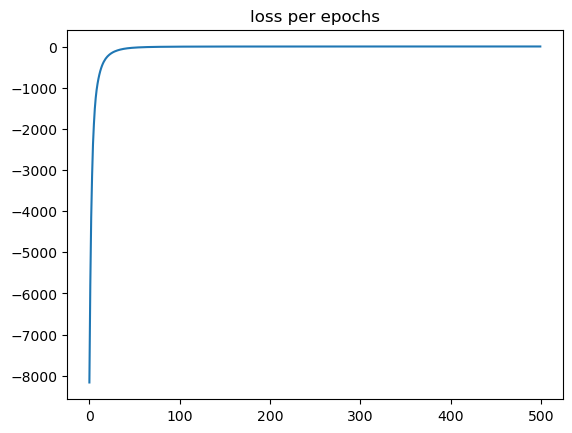

train score: 1.0


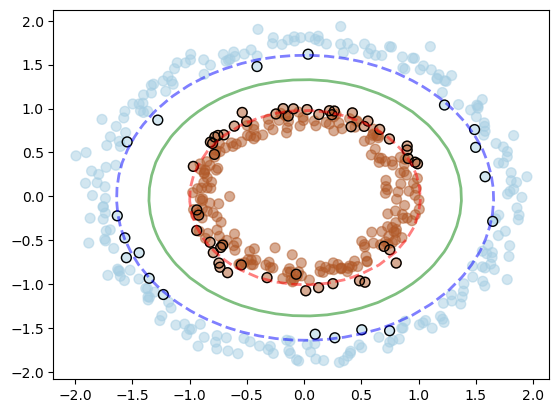

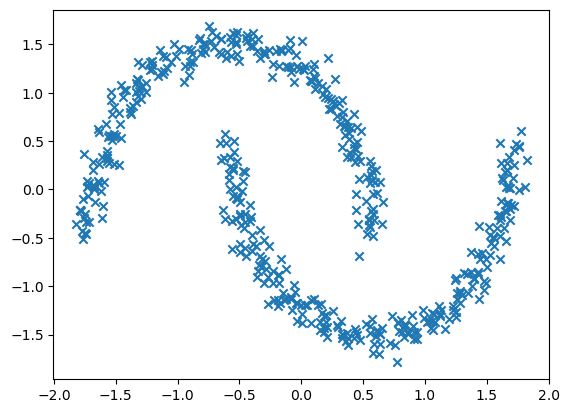

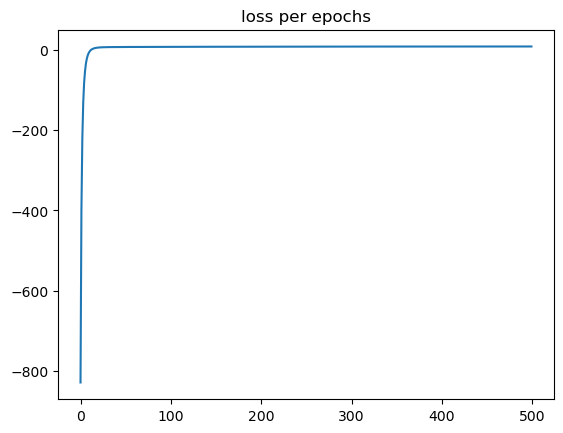

train score: 1.0


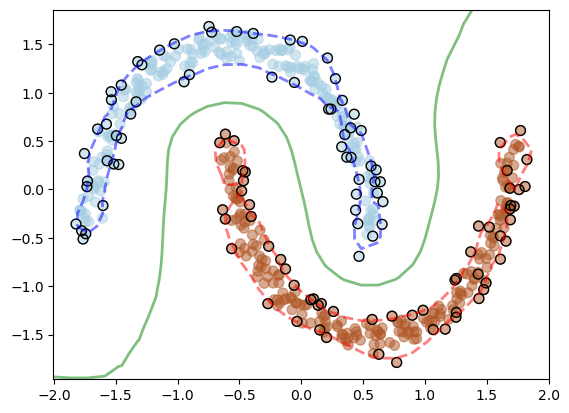

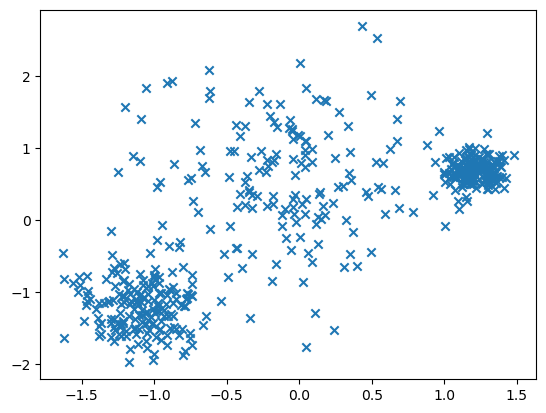

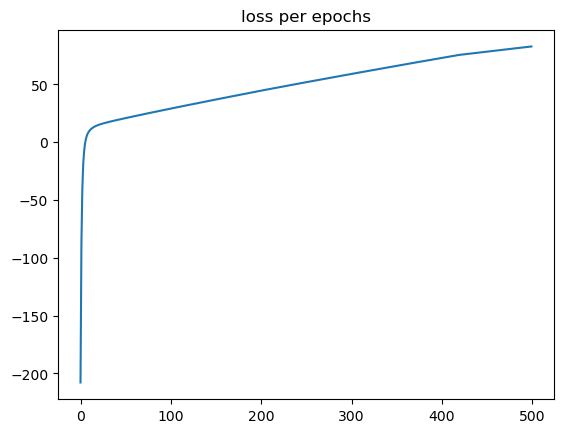

train score: 0.988


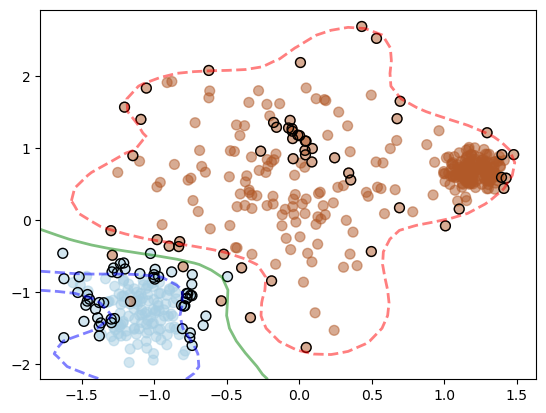

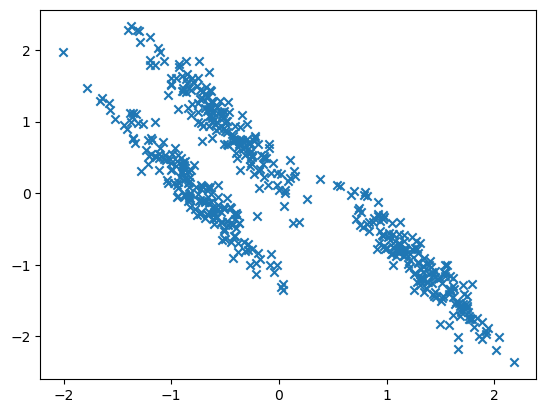

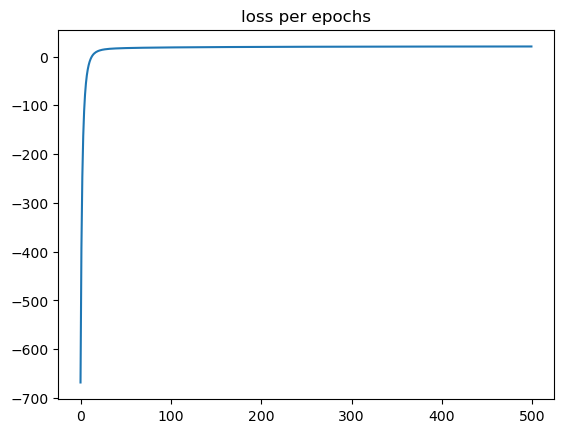

train score: 1.0


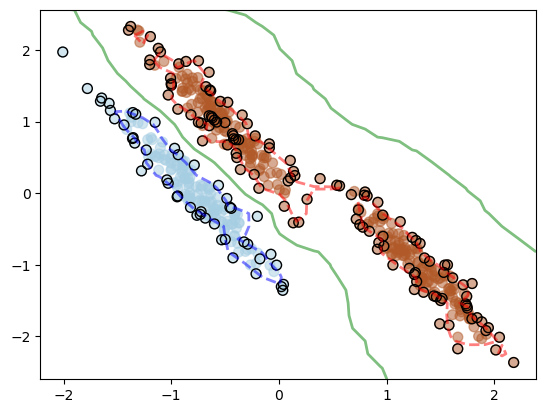

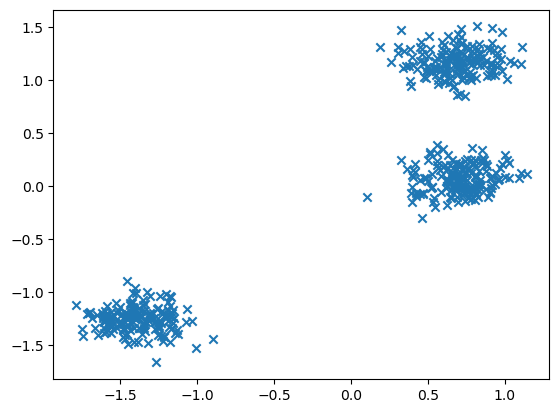

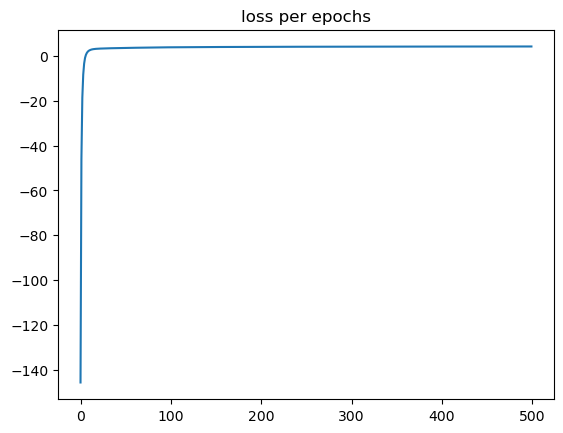

train score: 1.0


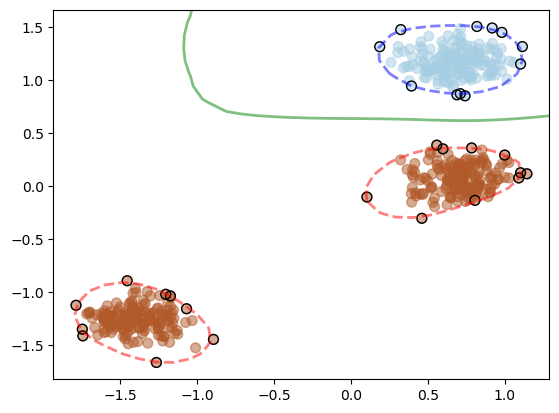

In [16]:

  
dataset,algo_params=(datasets[0])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1

svm = SVMDualProblem(C=10.0, kernel='poly', degree=2)
svm.fit(X, y, lr=1e-3)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()

dataset,algo_params=(datasets[1])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1

svm = SVMDualProblem(C=10.0, kernel='rbf', sigma=0.5)
svm.fit(X, y, lr=1e-2)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()

dataset,algo_params=(datasets[2])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1
y[y == 1] = 1
y[y == 2] = 1

svm = SVMDualProblem(C=10, kernel='rbf', sigma=0.8)
svm.fit(X, y, lr=1e-2)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()  

dataset,algo_params=(datasets[3])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1
y[y == 1] = 1
y[y == 2] = 1    

svm = SVMDualProblem(C=10.0, kernel='rbf', sigma=0.25)
svm.fit(X, y, lr=1e-2)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary() 

dataset,algo_params=(datasets[4])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1
y[y == 1] = 1
y[y == 2] = 1    

svm = SVMDualProblem(C=10.0, kernel='rbf', sigma=0.5)
svm.fit(X, y, lr=1e-2)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()  

          

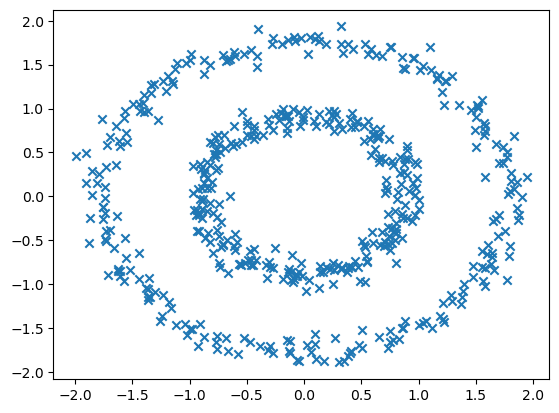

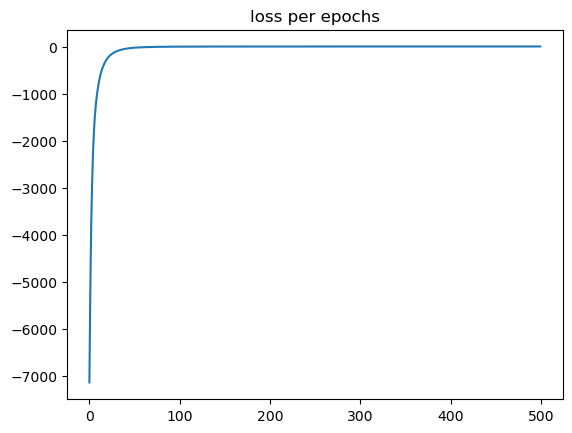

train score: 1.0


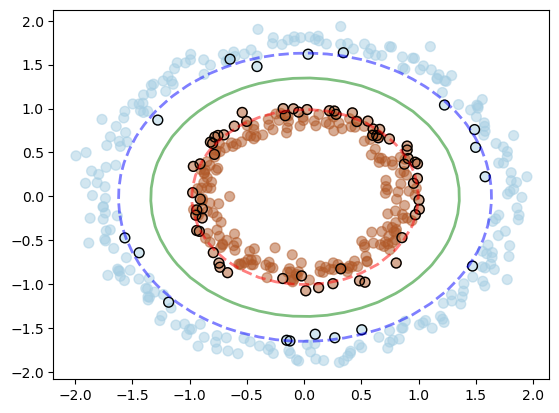

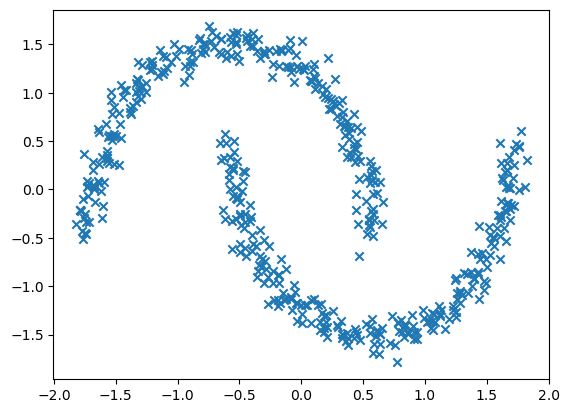

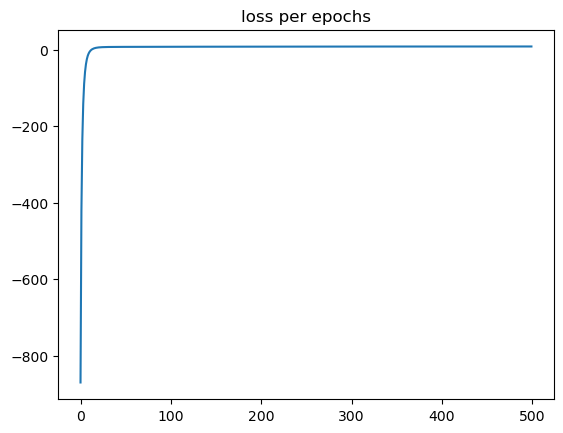

train score: 1.0


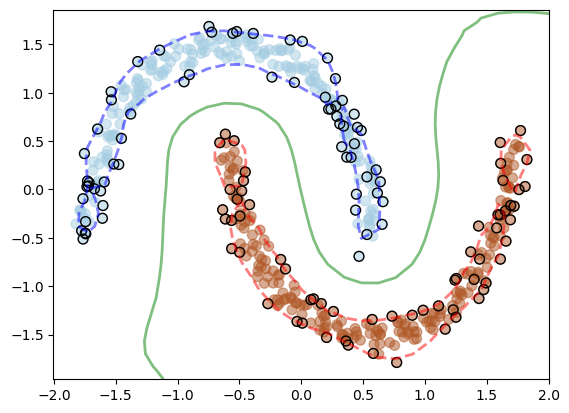

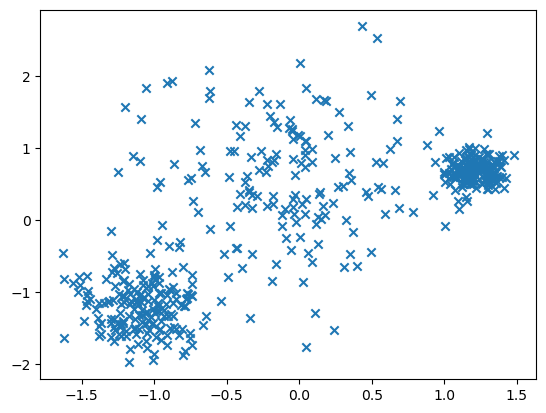

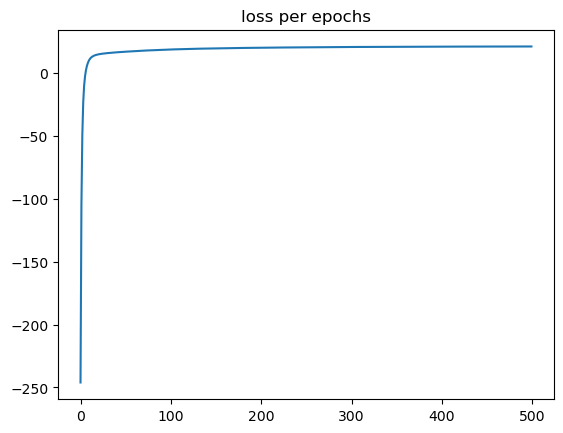

train score: 0.988


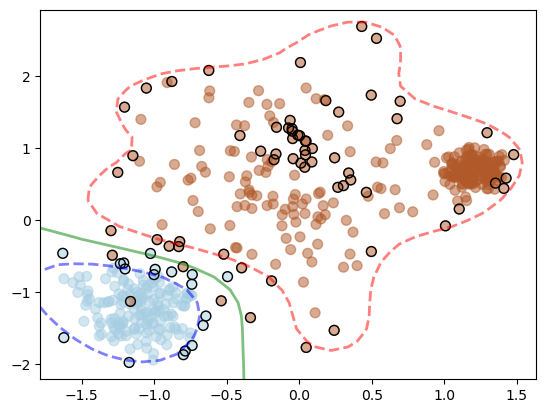

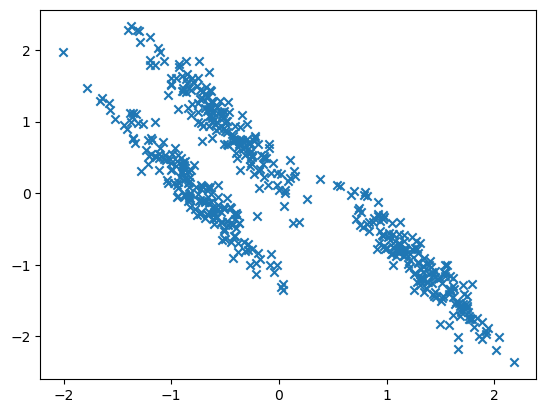

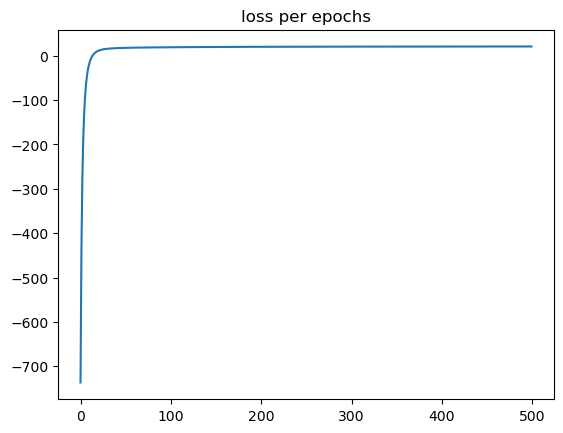

train score: 1.0


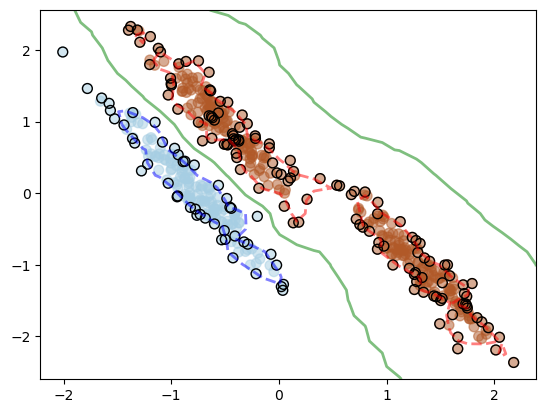

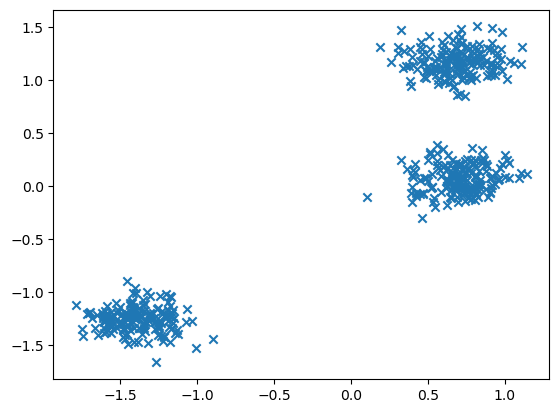

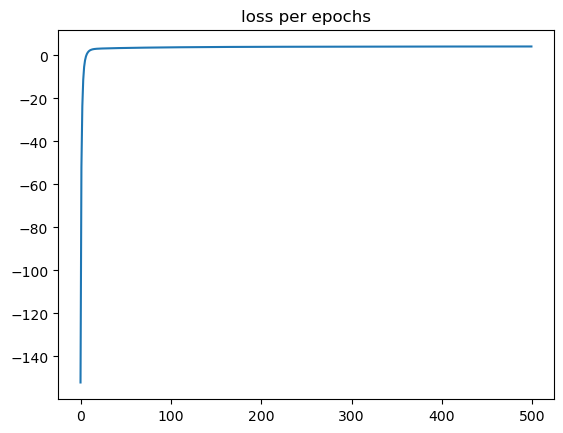

train score: 1.0


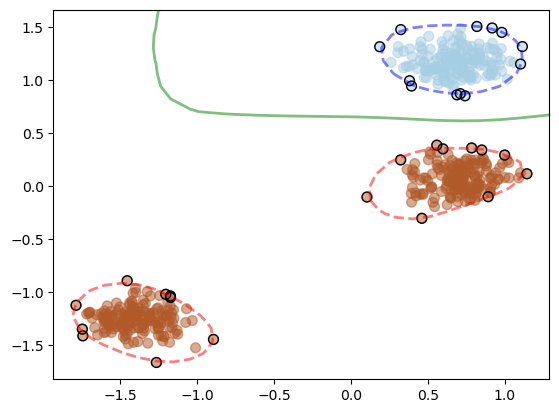

In [17]:
dataset,algo_params=(datasets[0])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1

svm = SVMDualProblem(C=1.0, kernel='poly', degree=2)
svm.fit(X, y, lr=1e-3)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()

dataset,algo_params=(datasets[1])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1

svm = SVMDualProblem(C=1.0, kernel='rbf', sigma=0.5)
svm.fit(X, y, lr=1e-2)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()

dataset,algo_params=(datasets[2])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1
y[y == 1] = 1
y[y == 2] = 1

svm = SVMDualProblem(C=1, kernel='rbf', sigma=0.8)
svm.fit(X, y, lr=1e-2)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()  

dataset,algo_params=(datasets[3])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1
y[y == 1] = 1
y[y == 2] = 1    

svm = SVMDualProblem(C=1.0, kernel='rbf', sigma=0.25)
svm.fit(X, y, lr=1e-2)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary() 

dataset,algo_params=(datasets[4])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1
y[y == 1] = 1
y[y == 2] = 1    

svm = SVMDualProblem(C=1.0, kernel='rbf', sigma=0.5)
svm.fit(X, y, lr=1e-2)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()  

          

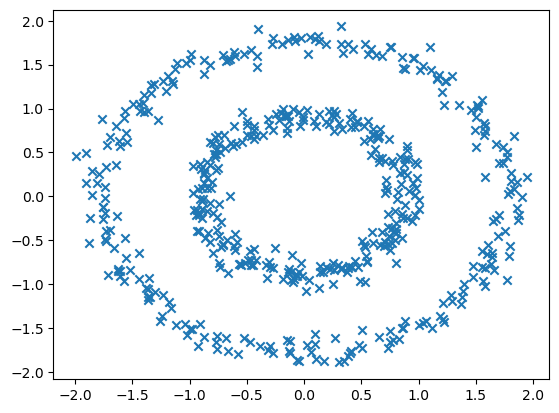

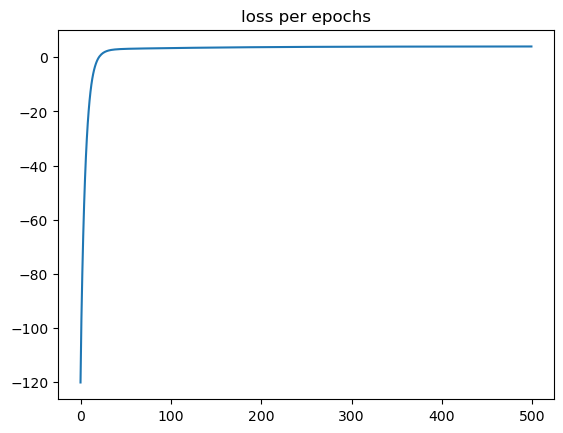

train score: 1.0


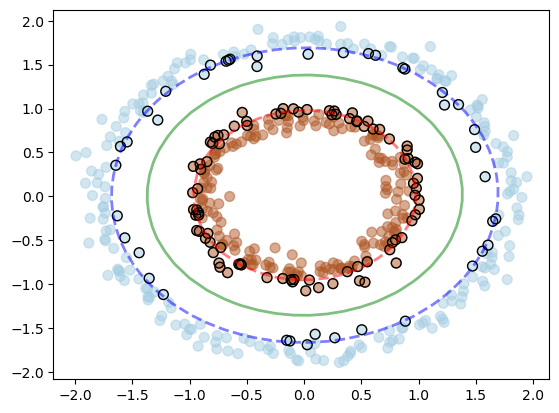

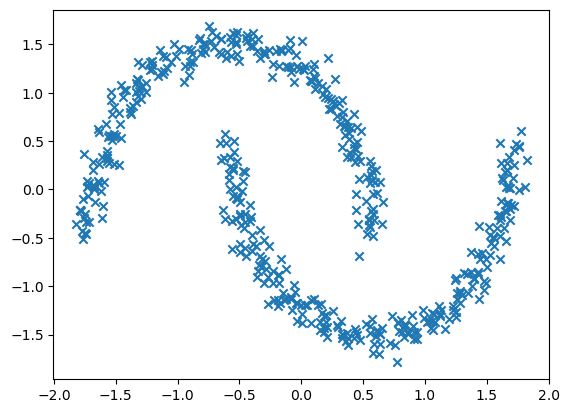

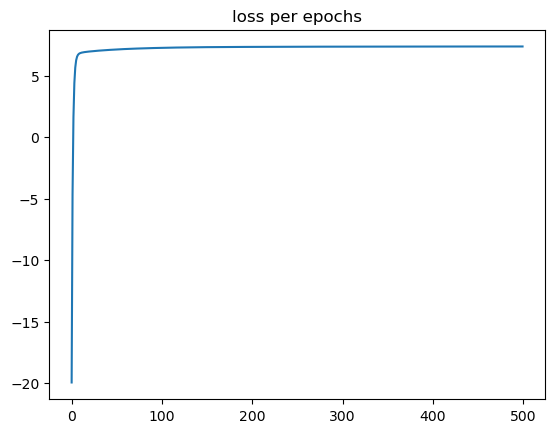

train score: 1.0


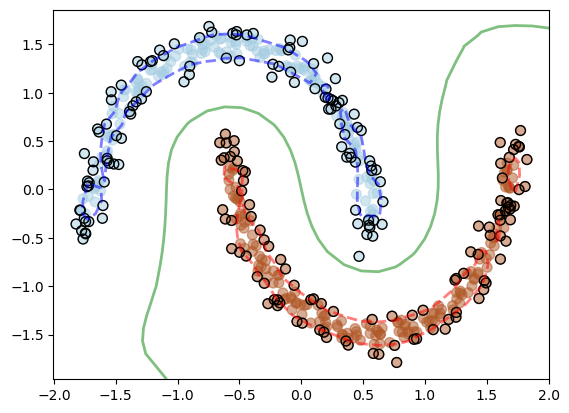

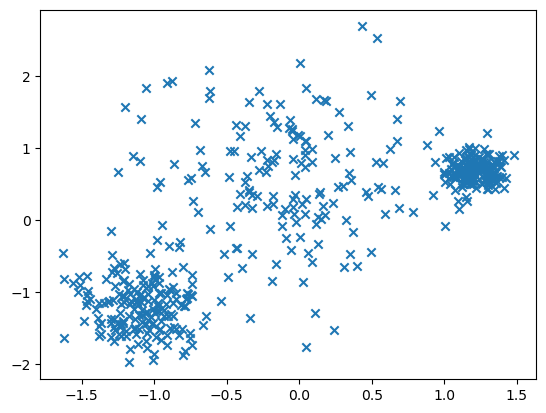

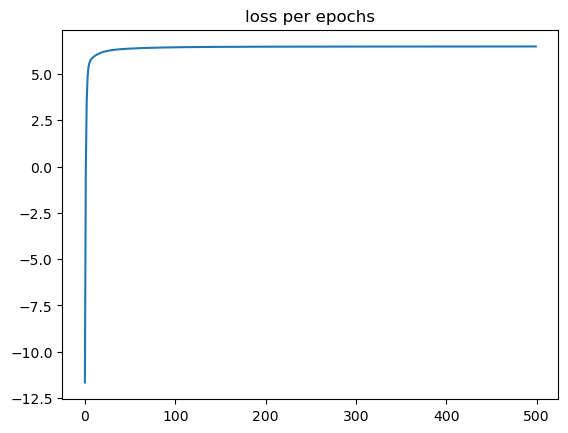

train score: 0.988


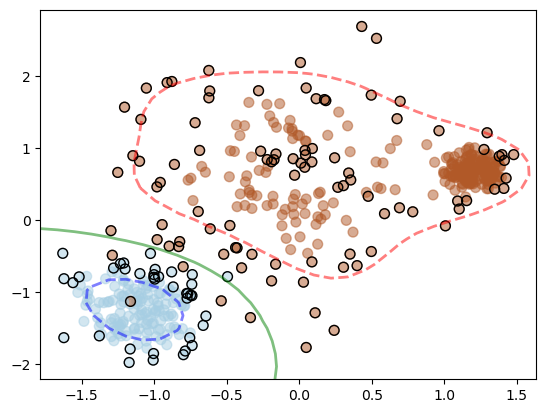

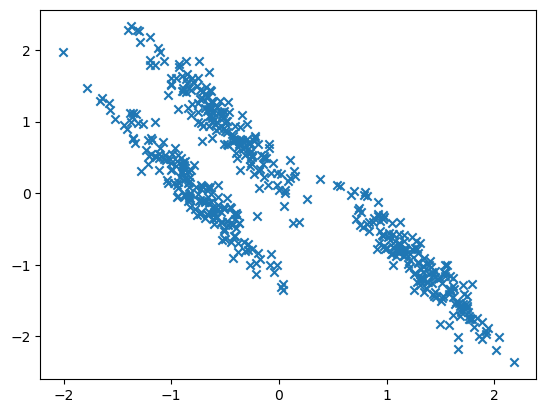

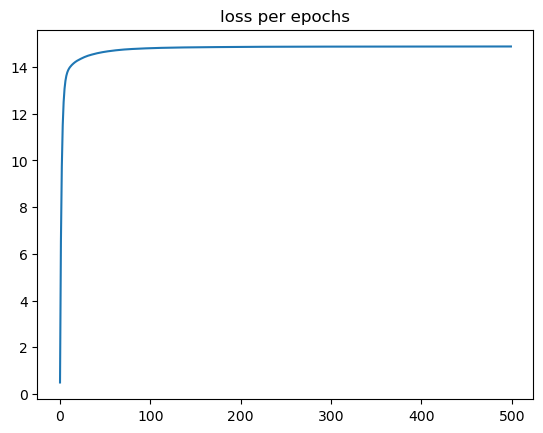

train score: 1.0


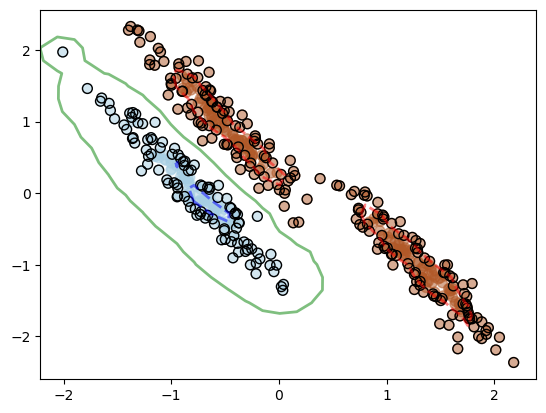

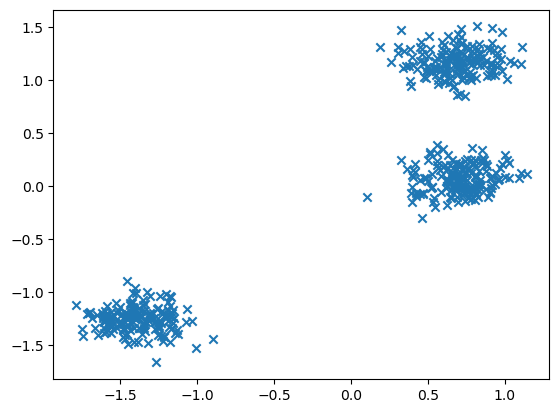

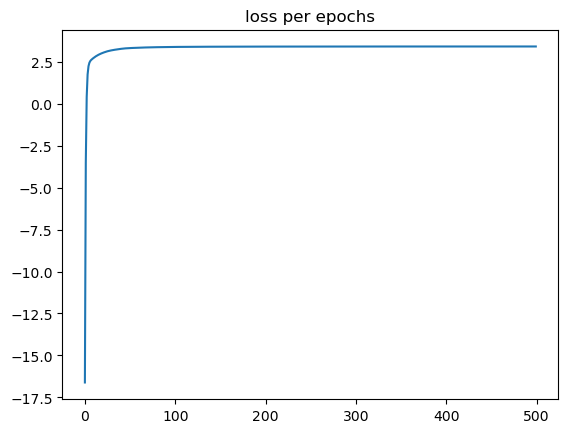

train score: 1.0


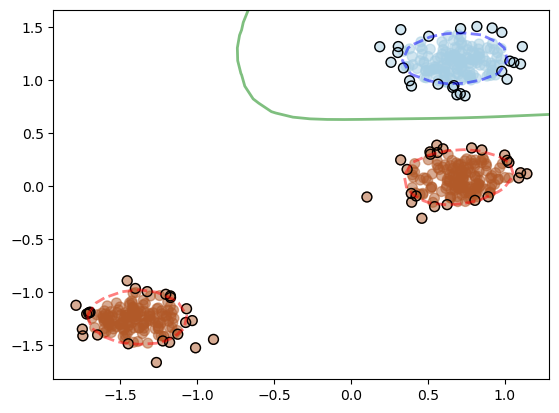

In [18]:
dataset,algo_params=(datasets[0])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1

svm = SVMDualProblem(C=0.1, kernel='poly', degree=2)
svm.fit(X, y, lr=1e-3)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()

dataset,algo_params=(datasets[1])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1

svm = SVMDualProblem(C=0.1, kernel='rbf', sigma=0.5)
svm.fit(X, y, lr=1e-2)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()

dataset,algo_params=(datasets[2])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1
y[y == 1] = 1
y[y == 2] = 1

svm = SVMDualProblem(C=0.1, kernel='rbf', sigma=0.8)
svm.fit(X, y, lr=1e-2)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()  

dataset,algo_params=(datasets[3])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1
y[y == 1] = 1
y[y == 2] = 1    

svm = SVMDualProblem(C=0.1, kernel='rbf', sigma=0.25)
svm.fit(X, y, lr=1e-2)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary() 

dataset,algo_params=(datasets[4])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1
y[y == 1] = 1
y[y == 2] = 1    

svm = SVMDualProblem(C=0.1, kernel='rbf', sigma=0.5)
svm.fit(X, y, lr=1e-2)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()  

          

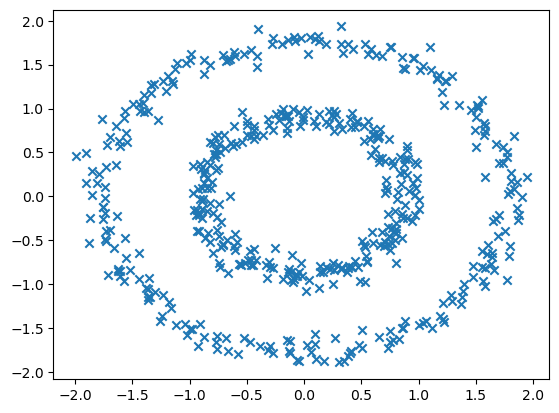

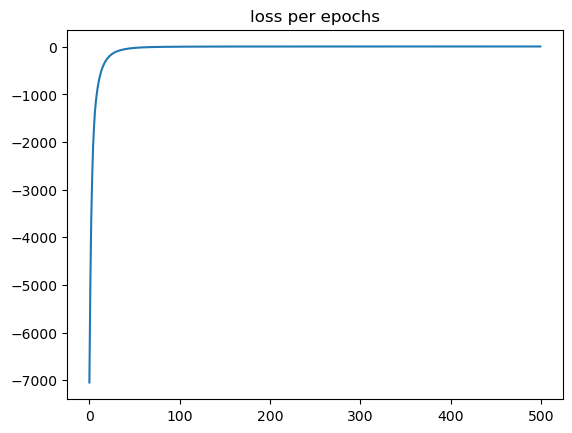

train score: 1.0


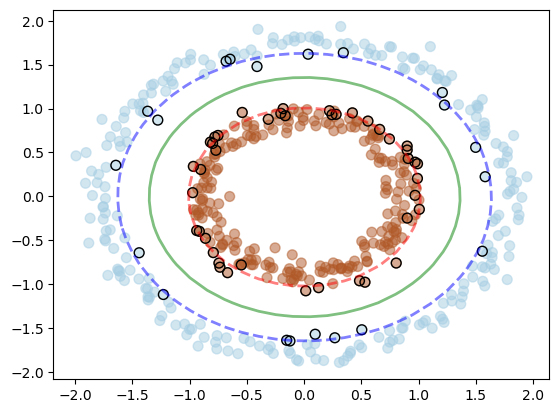

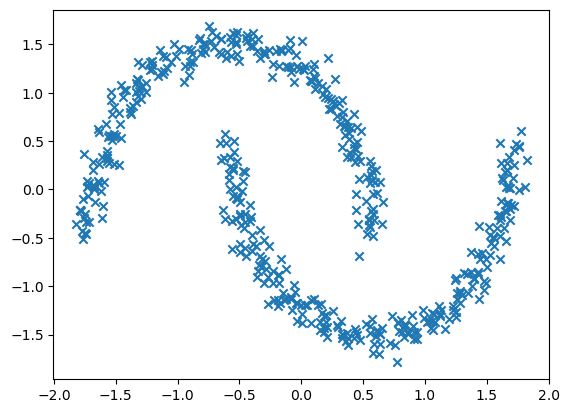

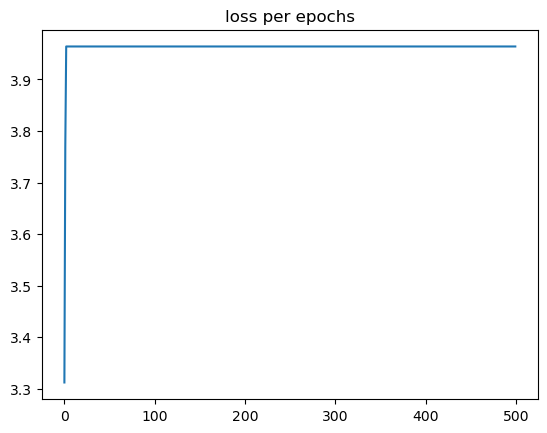

train score: 0.998


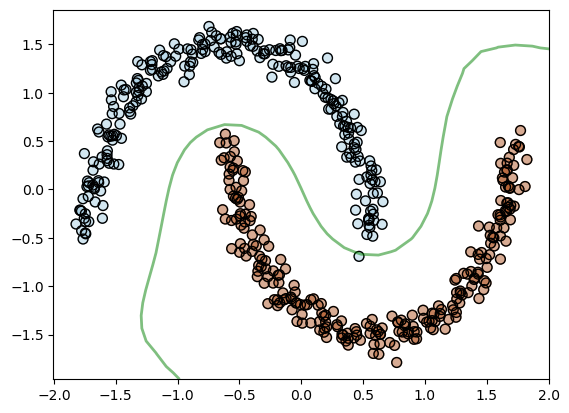

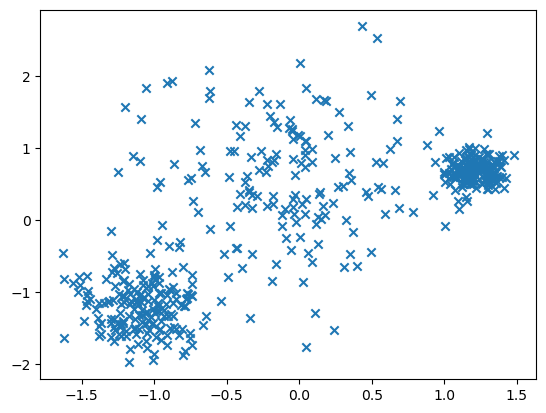

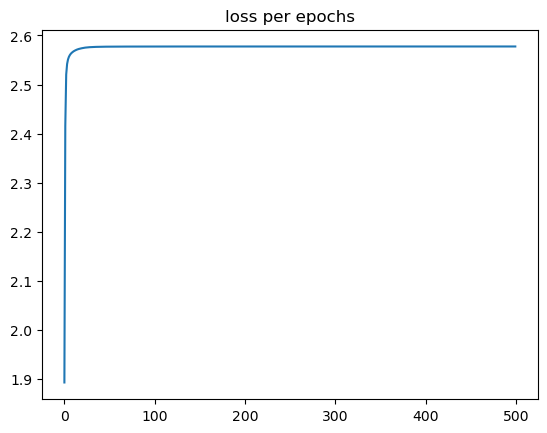

train score: 0.988


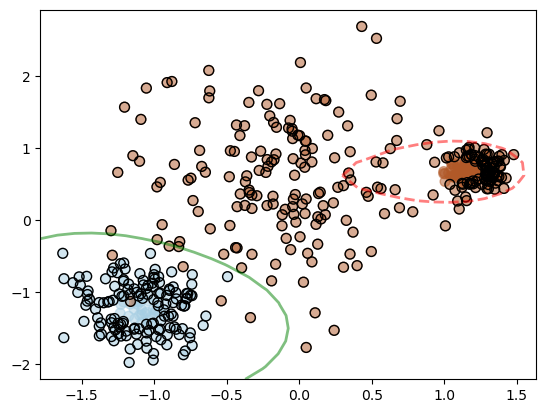

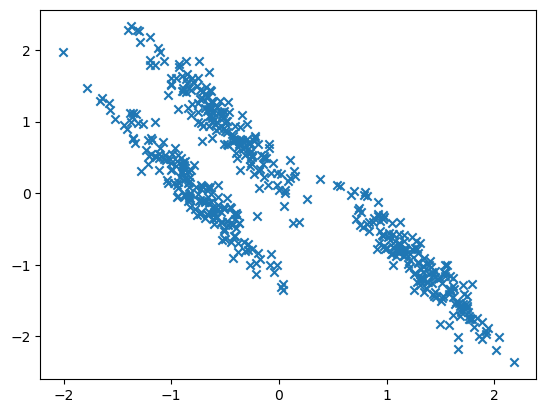

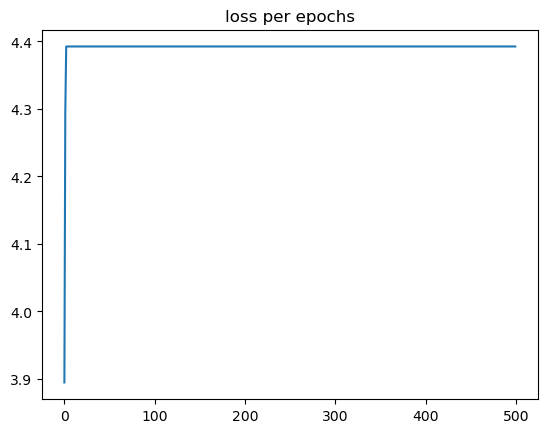

train score: 0.846


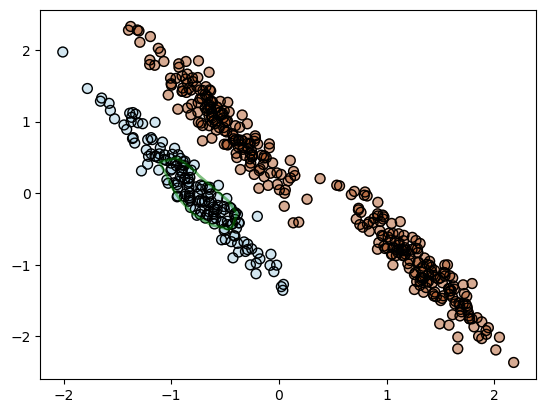

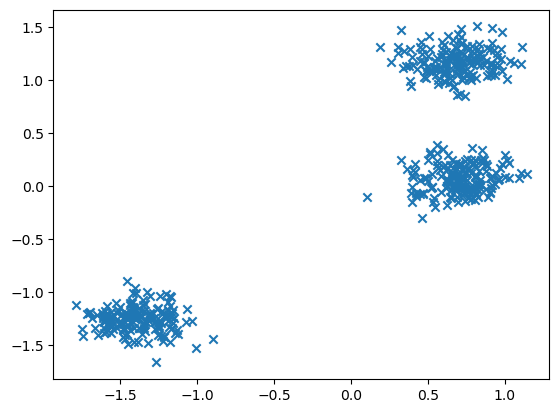

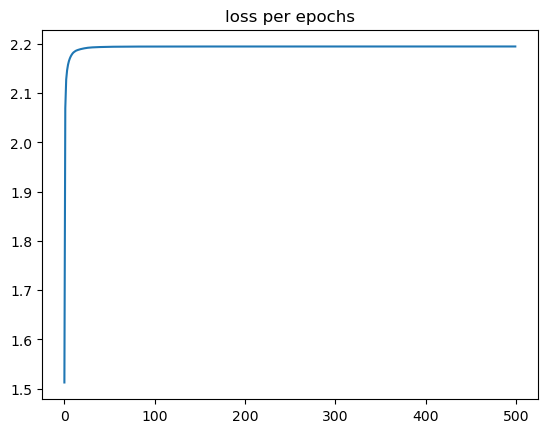

train score: 1.0


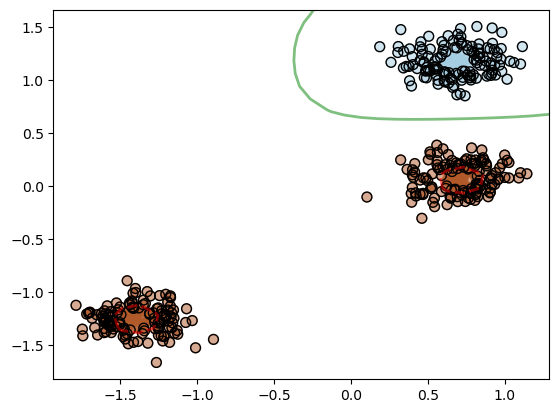

In [19]:
dataset,algo_params=(datasets[0])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1

svm = SVMDualProblem(C=10000, kernel='poly', degree=2)
svm.fit(X, y, lr=1e-3)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()

dataset,algo_params=(datasets[1])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1

svm = SVMDualProblem(C=0.01, kernel='rbf', sigma=0.5)
svm.fit(X, y, lr=1e-2)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()

dataset,algo_params=(datasets[2])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1
y[y == 1] = 1
y[y == 2] = 1

svm = SVMDualProblem(C=0.01, kernel='rbf', sigma=0.8)
svm.fit(X, y, lr=1e-2)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()  

dataset,algo_params=(datasets[3])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1
y[y == 1] = 1
y[y == 2] = 1    

svm = SVMDualProblem(C=0.01, kernel='rbf', sigma=0.25)
svm.fit(X, y, lr=1e-2)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary() 

dataset,algo_params=(datasets[4])
X,y=(dataset)
X=StandardScaler().fit_transform(X)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.show()
y[y == 0] = -1
y[y == 1] = 1
y[y == 2] = 1    

svm = SVMDualProblem(C=0.01, kernel='rbf', sigma=0.5)
svm.fit(X, y, lr=1e-2)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()  

          